In [1]:
import sys
packages = [
    '../dataset/',
    '../utils/',
    '../optimizer/',
    '../loss/',
    '../model/'
]
sys.path.extend(packages)

from sklearn.model_selection import KFold
from util import getNowTime
from tqdm import tqdm
from brpnet.model import UNet
from loss import dice_loss, smooth_truncated_loss, compute_loss_list
from adamw_r.cyclic_scheduler import CyclicLRWithRestarts, ReduceMaxLROnRestart
from adamw_r.adamw import AdamW
from ImageProcess.ImgShow import showLineImg
from dataset.PathologyData import PathologyDataSet
from dataset.KumarPatchDataSet import KumarPatchDataSet
import cv2
import torch.nn.functional as F
import time
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.nn as nn
from DataUtil import kfold_list
from postProcess.post_proc import post_proc
from metrics import get_fast_aji,remap_label

# 导入自己定义的一些需要的包
print('获取到的当前是时间： ', getNowTime())

获取到的当前是时间：  2021-01-02_13_49_09


In [2]:
imgs_train = np.load('../dataset/kumarDataset/train/trainDataSet.npy')
labels_train = np.load('../dataset/kumarDataset/labels/labelDataSet.npy')
bounds_train = np.load('../dataset/kumarDataset/bounds/boundDataSet.npy')

In [3]:
CFG = {
    "batch_size": 4,
    "num_epoch":1000,
    # 不同损失所占的额权重比
    "dice_weight":0.5
}

In [4]:
# 获取训练集的数据
def getTrainDataSet(imgs,labels,bounds,batch_size):
    pathologyData = PathologyDataSet(imgs, labels, bounds)
    pathologyDataloader = DataLoader(pathologyData, shuffle=True, batch_size=batch_size)
    return pathologyData,pathologyDataloader

def train(model, device, dataloader, lossfn, optimizer, scheduler,dice_weight=0.5):
    model.train()
    scheduler.step()
    runningloss = 0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    sample_num = 0
    lossesList = []
    for index, (image, label, boundary) in pbar:
        b, _, h, w = image.shape
        # 输入数据
        image = image.float().to(device)
        label = label.float().to(device).view(b, 1, h, w)
        boundary = boundary.float().to(device).view(b, 1, h, w)
        # 
        label_s1 = F.interpolate(label, scale_factor=0.5, mode='bilinear')
        label_s2 = F.interpolate(label, scale_factor=0.25, mode='bilinear')
        label_s3 = F.interpolate(label, scale_factor=0.125, mode='bilinear')
        boundary_s1 = F.interpolate(boundary, scale_factor=0.5, mode='bilinear')
        boundary_s2 = F.interpolate(boundary, scale_factor=0.25, mode='bilinear')
        boundary_s3 = F.interpolate( boundary, scale_factor=0.125, mode='bilinear')
        # 计算损失
        sout, sout_0, sout_1, sout_2, sout_3, cout, cout_0, cout_1, cout_2, cout_3 = model(image)
        seg_stl_losses = lossfn(smooth_truncated_loss, [sout, sout_0, sout_1, sout_2, sout_3], [label, label, label_s1, label_s2, label_s3])
        seg_dsc_losses = lossfn(dice_loss, [sout], [label])
        bnd_stl_losses = lossfn(smooth_truncated_loss, [cout, cout_0, cout_1, cout_2, cout_3], [boundary, boundary, boundary_s1, boundary_s2, boundary_s3])
        bnd_dsc_losses = lossfn(dice_loss, [cout], [boundary])
        # 定义loss的值
        loss = 0.0
        for iloss in seg_stl_losses:
            loss += iloss
        for iloss in seg_dsc_losses:
            loss += iloss*dice_weight
        for iloss in bnd_stl_losses:
            loss += iloss
        for iloss in bnd_dsc_losses:
            loss += iloss*dice_weight
        # 更新参数
        loss.backward() 
        optimizer.step()  # 这个才是更新模型
        scheduler.batch_step() # 更新学习率
        # 计算损失的和
        runningloss = runningloss*0.99 + loss.item()*0.01
        if((index+1) % 10):
            pbar.set_description(f'full train index: [{index+1} -- {len(dataloader)}] -- loss: {runningloss}')
            lossesList.append(runningloss)
    return lossesList


In [5]:
pathologyData,pathologyDataloader = getTrainDataSet(imgs_train,labels_train,bounds_train,CFG['batch_size'])

In [6]:
dataiter = iter(pathologyDataloader)

In [15]:
img, seg_label, boundary_label = dataiter.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
torch.Size([4, 3, 256, 256]) torch.Size([4, 256, 256]) torch.Size([4, 256, 256])


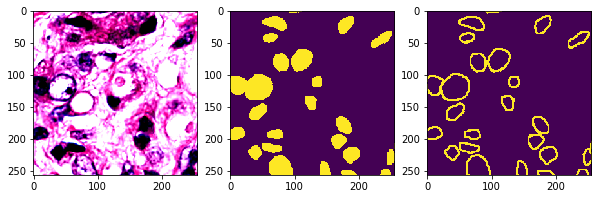

In [16]:
print(img.shape,seg_label.shape,boundary_label.shape)
seg_label_numpy = seg_label.numpy()
boundary_label_numpy = boundary_label.numpy()
img_numpy = img.numpy()
img_numpy = np.transpose(img_numpy,(0,2,3,1))
showLineImg([img_numpy[0],seg_label_numpy[0],boundary_label_numpy[0]])